# Мрежи vs. равенки

**Networks**

**Complete networks**

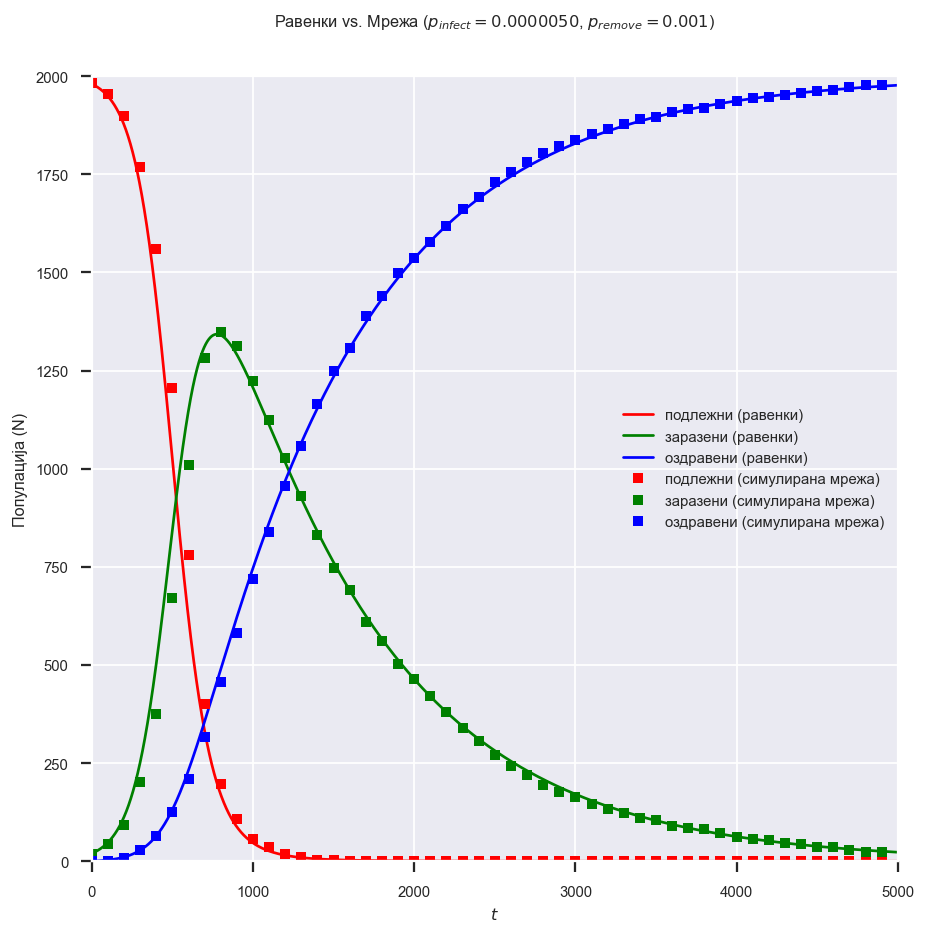

In [3]:
"""

 Created on 20-Feb-21
 @author: Kiril Zelenkovski

"""

import numpy
import networkx
import epydemic
import matplotlib
import matplotlib.pyplot as plt
import seaborn
matplotlib.rcParams['figure.dpi'] = 130


def make_sir(beta, alpha):
    # turn the equations into update functions
    def dS(S, I, R):
        return -beta * S * I

    def dI(S, I, R):
        return beta * S * I - alpha * I

    def dR(S, I, R):
        return alpha * I

    # return the three functions
    return (dS, dI, dR)


def epidemic_sir(T, N, pInfected, pInfect, pRemove):
    # create the equations for these parameters
    (dS, dI, dR) = make_sir(pInfect, pRemove)

    # initial conditions
    sss = [N * (1.0 - pInfected)]
    iss = [N * pInfected]
    rss = [0]

    # push the initial conditions through the differential equations
    for t in range(1, T):
        ds = dS(sss[-1], iss[-1], rss[-1])
        di = dI(sss[-1], iss[-1], rss[-1])
        dr = dR(sss[-1], iss[-1], rss[-1])
        sss.append(sss[-1] + ds)
        iss.append(iss[-1] + di)
        rss.append(rss[-1] + dr)

    # return the time series
    return (list(range(0, T)), sss, iss, rss)


N = 2000
T = 5000
pInfected = 0.01
pRemove = 0.001


class MonitoredSIR(epydemic.SIR, epydemic.Monitor):

    def __init__(self):
        super(MonitoredSIR, self).__init__()

    def build(self, params):
        '''Build the observation process.

        :param params: the experimental parameters'''
        super(MonitoredSIR, self).build(params)

        # also monitor other compartments
        self.trackNodesInCompartment(epydemic.SIR.SUSCEPTIBLE)
        self.trackNodesInCompartment(epydemic.SIR.REMOVED)


def network_sir(T, g, pInfected, pInfect, pRemove):
    # create the simulator
    m = MonitoredSIR()
    m.setMaximumTime(T)
    e = epydemic.SynchronousDynamics(m, g)

    # set the simulation parameters
    param = dict()
    param[epydemic.SIR.P_INFECTED] = pInfected
    param[epydemic.SIR.P_INFECT] = pInfect
    param[epydemic.SIR.P_REMOVE] = pRemove
    param[epydemic.Monitor.DELTA] = T / 50  # 50 samples

    # run the simulation
    rc = e.set(param).run()

    # extract the time series
    results = e.experimentalResults()[MonitoredSIR.TIMESERIES]
    ts = results[MonitoredSIR.OBSERVATIONS]
    sss = results[epydemic.SIR.SUSCEPTIBLE]
    iss = results[epydemic.SIR.INFECTED]
    rss = results[epydemic.SIR.REMOVED]

    # return the time series
    return (ts, sss, iss, rss)


g = networkx.complete_graph(N)


matplotlib.style.use('seaborn')
seaborn.set_context("notebook", font_scale=.75)

fig = plt.figure(figsize=(8, 8))
ax = fig.gca()

pInfect = 0.000005  # chosen simply for illustration

# run the epidemic equations
(ts, sss, iss, rss) = epidemic_sir(T, N, pInfected, pInfect, pRemove)
ax.plot(ts, sss, 'r-', label='подлежни (равенки)')
ax.plot(ts, iss, 'g-', label='заразени (равенки)')
ax.plot(ts, rss, 'b-', label='оздравени (равенки)')

# run the corresponding simulation
(sim_ts, sim_sss, sim_iss, sim_rss) = network_sir(T, g, pInfected, pInfect, pRemove)
ax.plot(sim_ts, sim_sss, 'rs', label='подлежни (симулирана мрежа)')
ax.plot(sim_ts, sim_iss, 'gs', label='заразени (симулирана мрежа)')
ax.plot(sim_ts, sim_rss, 'bs', label='оздравени (симулирана мрежа)')

# fine-tune the figure
plt.title(
    'Равенки vs. Мрежа ($p_{\\mathit{infect}} = ' + '{b:.7f}$, '.format(b=pInfect) + '$p_{remove} = ' + '{a}$)'.format(
        a=pRemove), y=1.05)
ax.set_xlabel('$t$')
ax.set_xlim([0, T])
ax.set_ylabel('Популација (N)')
ax.set_ylim([0, N])
ax.legend(loc='center right')
plt.savefig('images/2_1_network-same-beta-alpha.svg')
plt.show()

**Making fewer connections**

**Characterising a network’s topology**